In [1]:
import os,sys,glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils import util
from tqdm import tqdm
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import roc_curve, precision_recall_curve, auc


one class classification regime<br>
One class SVM <br>
Support Vector Data Descriptor (SVDD) <br>
one class multi max probability machine <br>
dual slope min max <br>
Generalized One-class Discriminative Sub-spaces (GODS) <br>

In [2]:
### one-class SVM pseudocode
def one_class_svm(X, nu=0.1, gamma='auto'):
    clf = OneClassSVM(nu=nu, kernel='rbf', gamma=gamma)
    clf.fit(X)
    return clf

In [2]:
df = pd.read_pickle('data/df_rotamer.pkl')
df = df[df['num_NN_atom'] >0] # meaningful binding site data

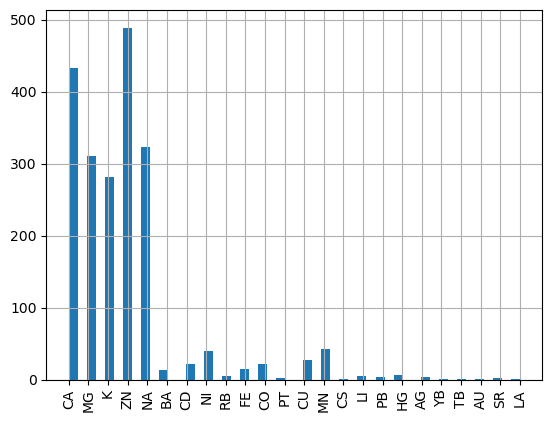

In [3]:
df['metal'].hist(bins=50)
plt.xticks(rotation='vertical')
plt.show()

In [4]:
metals = []
for metal in df['metal'].unique():
    if sum(df['metal']==metal) >= 100:
        metals.append(metal)

In [50]:
# df_CA = df[df['metal']=='CA']
# df_MG = df[df['metal']=='MG']
# df_K = df[df['metal']=='K']
# df_ZN = df[df['metal']=='ZN']


In [327]:
# df_MG[df_MG['num_NN_atom'] >0] #.hist()#['NN_atom_'] #['NN_atom_properties'][0]
# df_K[df_K['num_NN_atom'] >0] #.hist()#['NN_atom_'] #['NN_atom_properties'][0]
# df_ZN[df_ZN['num_NN_atom'] >0] #.hist()#['NN_atom_'] #['NN_atom_properties'][0]

In [52]:
# df_CA = df_CA[df_CA['num_NN_atom'] > 0] #.hist()#['NN_atom_'] #['NN_atom_properties'][0]

In [57]:
# df_CA_strong = df_CA[df_CA['num_NN_atom'] > 1]

In [6]:
# ij=6
# df_CA['NN_atom_properties'][ij], df_CA['num_NN_atom'][ij]

In [332]:
# df_CA_strong

In [116]:
# df_CA['NN_atom_properties'][0].keys()

dict_keys(['atom_type', 'l2_d', 'van_der_waals_radius', 'electronegativity', 'unshared_electron', 'valency'])

In [6]:
#one_hot encode all data to a vector of 1x8, 0 if not present, non-0 if present
#dict_keys(['atom_type', 'l2_d', 'van_der_waals_radius', 'electronegativity', 'unshared_electron', 'valency'])
def get_df_properties(df_metal):
    df_properties = {'pdb':[], 'pdb_id':[], 'NN_atoms':[], 'l2d':[], 'van_der_waals_radius':[], 'electronegativity':[], 'unshared_electron':[], 'valency':[]}
    for i in range(len(df_metal)):
        NN_atoms = np.zeros(8)
        l2d = np.zeros(8)
        van_der_waals_radius = np.zeros(8)
        electronegativity = np.zeros(8)
        unshared_electron = np.zeros(8)
        valency = np.zeros(8)
        for j in range(df_metal['num_NN_atom'].values[i]):
                NN_atoms_val = len(df_metal['NN_atom_properties'].values[i]['atom_type'])
                NN_atoms[:NN_atoms_val] = 1
                l2d_val = df_metal['NN_atom_properties'].values[i]['l2_d']
                van_der_waals_radius_val = df_metal['NN_atom_properties'].values[i]['van_der_waals_radius']
                electronegativity_val = df_metal['NN_atom_properties'].values[i]['electronegativity']
                unshared_electron_val = df_metal['NN_atom_properties'].values[i]['unshared_electron']
                valency_val = df_metal['NN_atom_properties'].values[i]['valency']
                for k in range(NN_atoms_val):
                    l2d[k] = l2d_val[k]
                    van_der_waals_radius[k] = van_der_waals_radius_val[k]
                    electronegativity[k] = electronegativity_val[k]
                    unshared_electron[k] = unshared_electron_val[k]
                    valency[k] = valency_val[k]
        df_properties['NN_atoms'].append(NN_atoms)
        df_properties['l2d'].append(l2d)
        df_properties['van_der_waals_radius'].append(van_der_waals_radius)
        df_properties['electronegativity'].append(electronegativity)
        df_properties['unshared_electron'].append(unshared_electron)
        df_properties['valency'].append(valency)
        df_properties['pdb'].append(df_metal['pdb'].values[i])
        df_properties['pdb_id'].append(df_metal['pdb_id'].values[i])
    df_properties = pd.DataFrame(df_properties)
    return df_properties

In [7]:
# X_data = df_properties[['NN_atoms', 'l2d', 'van_der_waals_radius', 'electronegativity', 'unshared_electron', 'valency']]
# y_data = np.ones(np.shape(X_data)) # one class positive data
# len(X_data['van_der_waals_radius'])

In [7]:
def get_X_data(df_properties):
    X_data = df_properties[['NN_atoms', 'l2d', 'van_der_waals_radius', 'electronegativity', 'unshared_electron', 'valency']]
    y_data = np.ones(np.shape(X_data)) # one class positive data
    X_data_NN_atoms = X_data['NN_atoms'].values
    X_data_NN_atoms = np.concatenate(X_data_NN_atoms, axis=0)
    X_data_NN_atoms= np.reshape(X_data_NN_atoms, (len(X_data['NN_atoms']), 8))
    X_data_NN_atoms_corrupt = X_data_NN_atoms.copy()
    X_data_NN_atoms_corrupt = X_data_NN_atoms_corrupt - np.mean(X_data_NN_atoms,axis=0)*3*np.std(X_data_NN_atoms,axis=0)
    X_data_NN_atoms_corrupt = X_data_NN_atoms_corrupt.astype(int)
    X_data_NN_atoms_corrupt[X_data_NN_atoms_corrupt < 0] = 0

    X_data_l2d = X_data['l2d'].values
    X_data_l2d = np.concatenate(X_data_l2d, axis=0)
    X_data_l2d= np.reshape(X_data_l2d, (len(X_data['l2d']), 8))
    X_data_l2d_corrupt = X_data_l2d.copy()
    X_data_l2d_corrupt = X_data_l2d_corrupt + np.mean(X_data_l2d,axis=0)*2*np.std(X_data_l2d,axis=0)

    X_data_van_der_waals_radius = X_data['van_der_waals_radius'].values
    X_data_van_der_waals_radius = np.concatenate(X_data_van_der_waals_radius, axis=0)
    X_data_van_der_waals_radius= np.reshape(X_data_van_der_waals_radius, (len(X_data['van_der_waals_radius']), 8))
    X_data_van_der_waals_radius_corrupt = X_data_van_der_waals_radius.copy()
    X_data_van_der_waals_radius_corrupt = X_data_van_der_waals_radius_corrupt + np.std(X_data_van_der_waals_radius,axis=0)*2*(-1)*np.random.randint(-1,1)

    X_data_electronegativity = X_data['electronegativity'].values
    X_data_electronegativity = np.concatenate(X_data_electronegativity, axis=0)
    X_data_electronegativity= np.reshape(X_data_electronegativity, (len(X_data['electronegativity']), 8))
    X_data_electronegativity_corrupt = X_data_electronegativity.copy()
    X_data_electronegativity_corrupt = X_data_electronegativity_corrupt + np.std(X_data_electronegativity,axis=0)*2*(-1)**np.random.randint(-1,1)

    X_data_unshared_electron = X_data['unshared_electron'].values
    X_data_unshared_electron = np.concatenate(X_data_unshared_electron, axis=0)
    X_data_unshared_electron= np.reshape(X_data_unshared_electron, (len(X_data['unshared_electron']), 8))
    X_data_unshared_electron_corrupt = X_data_unshared_electron.copy()
    X_data_unshared_electron_corrupt = X_data_unshared_electron_corrupt + np.std(X_data_unshared_electron,axis=0)*2*(-1)**np.random.randint(-1,1)

    X_data_valency = X_data['valency'].values
    X_data_valency = np.concatenate(X_data_valency, axis=0)
    X_data_valency= np.reshape(X_data_valency, (len(X_data['valency']), 8))
    X_data_valency_corrupt = X_data_valency.copy()
    X_data_valency_corrupt = X_data_valency_corrupt + np.std(X_data_valency,axis=0)*2*(-1)**np.random.randint(-1,1)


    X_data = np.concatenate((X_data_NN_atoms, X_data_l2d, X_data_van_der_waals_radius, X_data_electronegativity, X_data_unshared_electron, X_data_valency), axis=1)
    y_data = np.ones(np.shape(X_data)[0]) # one class positive data
    X_data_corrupt = np.concatenate((X_data_NN_atoms_corrupt, X_data_l2d_corrupt, X_data_van_der_waals_radius_corrupt, X_data_electronegativity_corrupt, X_data_unshared_electron_corrupt, X_data_valency_corrupt), axis=1)
    y_data_corrupt = -1*np.ones(np.shape(X_data_corrupt)[0]) # one class pseudo-negative data
    #randomly take two-third of corrupt data, dont want to overwhelm the model with too much pseudo-negative data
    X_data_corrupt = X_data_corrupt[np.random.choice(X_data_corrupt.shape[0], int(X_data_corrupt.shape[0]*2/3), replace=False), :]
    y_data_corrupt = -1*np.ones(np.shape(X_data_corrupt)[0]) # one class pseudo-negative data

    X_data = np.concatenate((X_data, X_data_corrupt), axis=0)
    y_data = np.concatenate((y_data, y_data_corrupt), axis=0)
    return X_data, y_data

In [42]:
# X_data_NN_atoms_corrupt
# y_data_corrupt
# y_data

In [10]:
# X_data_corrupt = X_data + np.mean(X_data,axis=0)*3*np.std(X_data,axis=0)#*np.random.randn(np.shape(X_data_corrupt)[0], np.shape(X_data_corrupt)[1])
# y_data_corrupt = np.zeros(np.shape(X_data_corrupt)[0]) # one class negative data

In [22]:
# X_data_all = np.concatenate((X_data, X_data_corrupt), axis=0)
# y_data_all = np.concatenate((y_data, y_data_corrupt), axis=0)

In [271]:
# ### corupt X_data to generate psuedo negative data
# X_data_corrupt = X_data.copy()

# #X_data_corrupt['NN_atoms'] = X_data_corrupt['NN_atoms'] - np.tile(np.mean(X_data_corrupt['NN_atoms']), (len(X_data_corrupt['NN_atoms']), 1))
# #convert X_data_corrupt['NN_atoms'] to int, and replace negative values as 0
# #X_data_corrupt['NN_atoms'] = X_data_corrupt['NN_atoms'].astype(int)
# #X_data_corrupt['NN_atoms'][X_data_corrupt['NN_atoms'] < 0] = 0

# # X_data_corrupt['l2d'] = X_data_corrupt['l2d'] + np.mean(X_data_corrupt['l2d'])*2*np.std(X_data_corrupt['l2d'])*np.random.randn(len(X_data_corrupt['l2d']))
# # X_data_corrupt['van_der_waals_radius'] = X_data_corrupt['van_der_waals_radius'] + np.mean(X_data_corrupt['van_der_waals_radius'])*2*np.std(X_data_corrupt['van_der_waals_radius'])*np.random.randn(len(X_data_corrupt['van_der_waals_radius']))
# # X_data_corrupt['electronegativity'] = X_data_corrupt['electronegativity'] - np.mean(X_data_corrupt['electronegativity'])
# # X_data_corrupt['electronegativity'][X_data_corrupt['electronegativity'] < 0] = 0

# # X_data_corrupt['unshared_electron'] = X_data_corrupt['unshared_electron'] - np.mean(X_data_corrupt['unshared_electron'])
# # X_data_corrupt['unshared_electron'][X_data_corrupt['unshared_electron'] < 0] = 0


In [273]:
# X_data_all = np.concatenate((X_data, X_data_corrupt), axis=0)
# y_data_all = np.concatenate((y_data, y_data_corrupt), axis=0)

In [8]:
#pr_auc = auc(recall, precision)
def plot_ROC(fpr, tpr, roc, metal,show=1,outdir='weight/'):
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'(ROC) Curve for {metal} binding site prediction')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig(f'{outdir}/ROC_{metal}.png')
    if show:
        plt.show()
    #plt.show()

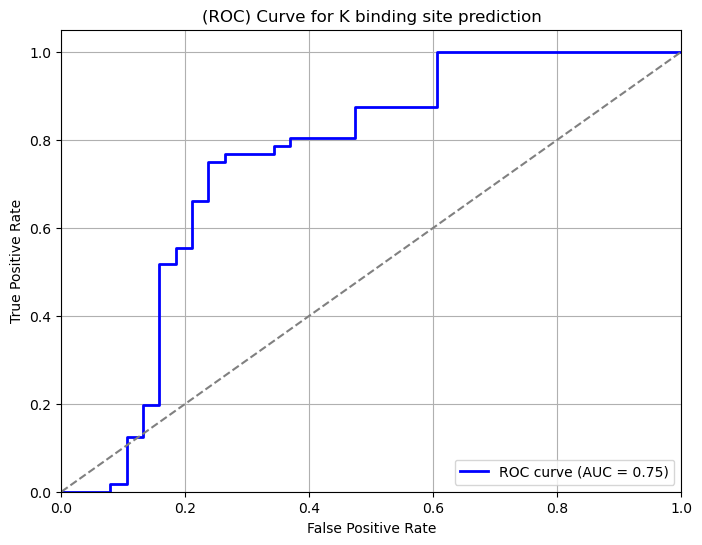

In [12]:
kernel = 'rbf'  # Kernel function  'rbf', 'linear', 'poly', 'sigmoid' rbf is best fitted for complex boundary
metals = ['K']#,'NA']
for metal in metals:
    gamma = 'scale'
    df_metal = df[df['metal']==metal]
    df_properties = get_df_properties(df_metal)
    for nu in np.linspace(0.1,0.0005,10):
        X_data_all, y_data_all = get_X_data(df_properties)
        X_train, X_test, y_train, y_test = train_test_split(X_data_all, y_data_all, test_size=0.2)#, random_state=42)
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train)
        # X_test_scaled = scaler.transform(X_test)
        X_train_scaled = X_train
        X_test_scaled = X_test
        model = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma, verbose=0, tol=1e-4, cache_size=500)
        model.fit(X_train_scaled)
        y_pred_train = model.predict(X_train_scaled)
        y_pred_test = model.predict(X_test_scaled)
        model.fit(X_train_scaled)
        train_score = model.score_samples(X_train_scaled)
        test_score = model.score_samples(X_test_scaled)
        test_scores = model.score_samples(X_test_scaled)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, -test_scores)  # Using negative scores as One-Class SVM's predict function outputs negative scores

        # Calculate Precision-Recall curve

        precision, recall, _ = precision_recall_curve(y_test, -test_scores)

        # Calculate Area Under ROC curve (AUC-ROC)
        roc_auc = auc(fpr, tpr)

        # Calculate Area Under Precision-Recall curve (AUC-PR)
        #pr_auc = auc(recall, precision)
        if roc_auc >= 0.7:
            joblib.dump(model, f'weight3/one_class_svm_{metal}_nu_{round(nu,4)}_roc_{round(roc_auc,3)}.pkl')#.format(metal, nu, roc_auc))
            plot_ROC(fpr, tpr, roc_auc, metal,outdir='weight3/')
            break
        # else:
        #     continue
        # break

In [44]:
# joblib.dump(model, f'weight/one_class_svm_tip_atom_{metal}.pkl')

In [57]:
# train_score = model.score_samples(X_train_scaled)
# test_score = model.score_samples(X_test_scaled)

# # Predict scores on the test set
# test_scores = model.score_samples(X_test_scaled)

# # Calculate ROC curve
# fpr, tpr, _ = roc_curve(y_test, -test_scores)  # Using negative scores as One-Class SVM's predict function outputs negative scores

# # Calculate Precision-Recall curve

# precision, recall, _ = precision_recall_curve(y_test, -test_scores)

# # Calculate Area Under ROC curve (AUC-ROC)
# roc_auc = auc(fpr, tpr)

# # Calculate Area Under Precision-Recall curve (AUC-PR)
# pr_auc = auc(recall, precision)

# # Plot ROC curve
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

In [23]:
### test
model_CA = joblib.load('weight3/one_class_svm_CA_nu_0.1_roc_0.72.pkl')


In [42]:
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
model_CA.predict(tmp)

array([1])

In [39]:
tmp = np.reshape(X_data_all[1], (1,48))

In [40]:
tmp

array([[  1.        ,   1.        ,   1.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          2.59703469,   2.71086121,   2.62000656,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
        152.        , 152.        , 152.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          3.44      ,   3.44      ,   3.44      ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          4.        ,   4.        ,   4.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          6.        ,   6.        ,   6.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ]])

In [22]:
X_data_all[1]#, y_data_all[1]

array([  1.        ,   1.        ,   1.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         2.59703469,   2.71086121,   2.62000656,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
       152.        , 152.        , 152.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         3.44      ,   3.44      ,   3.44      ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         4.        ,   4.        ,   4.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         6.        ,   6.        ,   6.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

In [52]:
metal = 'CA'
df_metal = df[df['metal']==metal]
df_properties = get_df_properties(df_metal)
X_data_all, y_data_all = get_X_data(df_properties)

In [ ]:
X_data_all

In [296]:
#test_score

In [329]:
# joblib.dump(model, 'weight/one_class_svm_tip_atom_CA.pkl')

['weight/one_class_svm_tip_atom_CA.pkl']

In [176]:
# np.ones(np.shape(X_data_corrupt['NN_atoms']))
# np.mean(X_data_corrupt['NN_atoms'])
# np.tile(np.mean(X_data_corrupt['NN_atoms']), (len(X_data_corrupt['NN_atoms']), 1))

(433, 8)

In [208]:
# tmp = np.asarray(X_data_corrupt['l2d'])
# tmp_matrix = np.concatenate(tmp, axis=0)
# tmp_matrix= np.reshape(tmp_matrix, (len(X_data_corrupt['NN_atoms']), 8))
# #3-np.tile(np.mean(X_data_corrupt['NN_atoms']), (len(X_data_corrupt['NN_atoms']), 1))

In [222]:
# tmp_matrix = np.concatenate(X_data['NN_atoms'], axis=0)